In [1]:
import pandas as pd
import numpy as np
import pyvista as pv
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from dash import Dash, html, dcc
import plotly.express as px
import plotly.graph_objects as go

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In this notebook, you should apply the techniques you learned for regression in a more realistic problem setting. We have a collection of bridges, which are modelled as 2D-beams, that all feature one defect. Our goal is to train a model to learn the location of this defect as a function of displacement measurements. Since sensors are expensive, we can only place them in five locations of the bridges. The assignments includes the following tasks:
- Select five locations for the sensors based on a visual inspection of the displacement field <!--, and extract the displacement measurements from the dataset -->
<!-- - Extract the defect location from the individual bridges-->
- Train a neural network to learn a mapping from the displacement measurements to the defect location, comment on the choice of hyperparameters (number of hidden layers, nodes per layer, ...)
- Visualise your results and evaluate the accuracy of your network

Let's take a look at the dataset first. It is csv-file, and a convenient way to read and manipulate this filetype is via the `Dataframe` of the `pandas` library. It is good practice to print a few lines of the dataset before performing the analysis. We load the dataset into a `Dataframe` from the `pandas` library and print a few rows from the top and bottom. The dataset consists of a collection of displacement fields of the bridges. We have total of 1000 briges, as can be seen from the tail of `df`, and 712 locations in which the displacements have been measures, as can be seen from the tail of `bar_0`, which is just a single sample we took from the dataset. Note that some of the columns are uniform for a specific sample owed to the structure of the dataset.

In [2]:
df = pd.read_csv('regression-data.csv')
bar_0 = df[df['sample'] == 0]
df.head()

,sample,E_pure,nu,deteriorations,location,node,x,y,dx,dy,E_true
0,0,10000.0,0.2,1,7.063183,0,0.0,0.0,0.000000,0.000000,10000.000000
1,0,10000.0,0.2,1,7.063183,1,10.0,0.0,0.028953,0.000000,9998.301731
2,0,10000.0,0.2,1,7.063183,2,10.0,2.0,0.002377,-0.005370,9998.301731
3,0,10000.0,0.2,1,7.063183,3,5.0,2.0,0.014410,-0.046229,9987.432772
4,0,10000.0,0.2,1,7.063183,4,0.0,2.0,0.026353,-0.005033,10000.000000


In [3]:
df.tail()

,sample,E_pure,nu,deteriorations,location,node,x,y,dx,dy,E_true
712995,999,10000.0,0.2,1,1.494755,708,9.889581,0.110419,0.026034,-0.003915,10000.000000
712996,999,10000.0,0.2,1,1.494755,709,9.889581,1.889581,0.003770,-0.006701,10000.000000
712997,999,10000.0,0.2,1,1.494755,710,5.221090,1.118279,0.014272,-0.046419,9999.841238
712998,999,10000.0,0.2,1,1.494755,711,1.492172,0.111827,0.004598,-0.023698,9892.946374
712999,999,10000.0,0.2,1,1.494755,712,4.809589,0.343110,0.013898,-0.046286,9999.478980


In [4]:
bar_0.tail()

,sample,E_pure,nu,deteriorations,location,node,x,y,dx,dy,E_true
708,0,10000.0,0.2,1,7.063183,708,9.889581,0.110419,0.026053,-0.003920,9997.864571
709,0,10000.0,0.2,1,7.063183,709,9.889581,1.889581,0.003715,-0.006708,9997.858176
710,0,10000.0,0.2,1,7.063183,710,5.221090,1.118279,0.014258,-0.046496,9971.220630
711,0,10000.0,0.2,1,7.063183,711,1.492172,0.111827,0.004574,-0.023654,9999.999979
712,0,10000.0,0.2,1,7.063183,712,4.809589,0.343110,0.013850,-0.046345,9989.634516


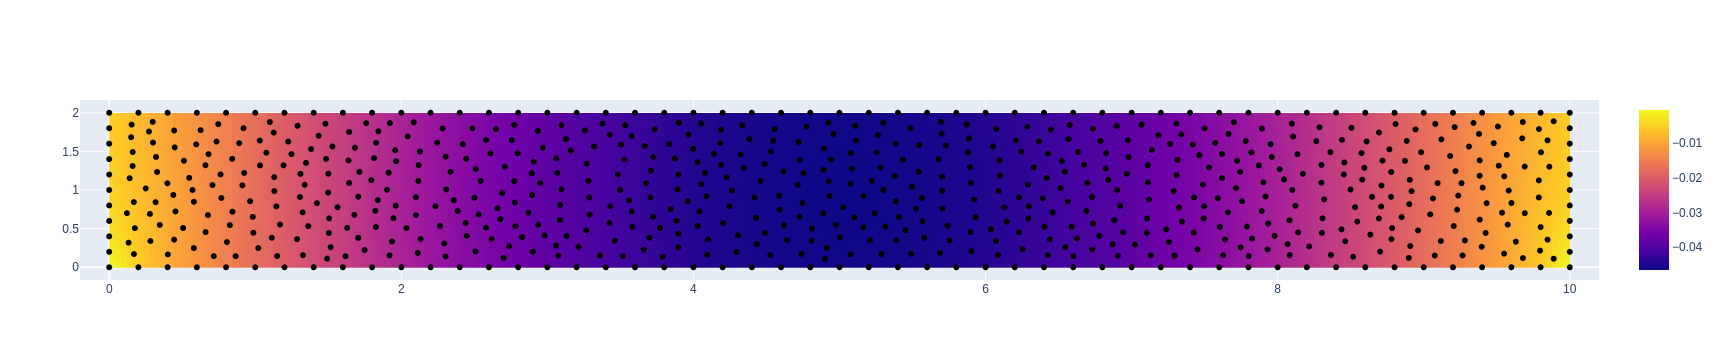

In [16]:
# extract data corresponding to one single bridge, an interpolate the displacements on a grid for plotting
bar_0 = df[df['sample'] == 0]
grid_x, grid_y = np.mgrid[0.02:9.98:250j, 0.02:1.98:50j]
grid_z = griddata(bar_0[['x','y']].to_numpy(), bar_0['dy'], (grid_x, grid_y))
# grid_z = griddata(bar_0[['x','y']].to_numpy(), np.sqrt(bar_0['dx']**2 + bar_0['dy']**2), (grid_x, grid_y))

# plot displacement-field and nodes
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grid_z.transpose(),
                         x=grid_x[:,0],
                         y=grid_y[0],
                         hoverinfo='skip',
                         name='heatmap'))

fig.add_trace(go.Scatter(x=bar_0['x'],
                         y=bar_0['y'],
                         mode='markers',
                         marker_color='black',
                         name='',
                         hovertemplate='<b>Node</b>: %{text}',
                         text=bar_0['node']))

fig.update_xaxes(range=(-0.2,10.2), constrain='domain')
# fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
fig.show()

In [63]:
# define measurement locations, get corresponding coord
measure_locs = [481, 461, 312, 41, 66]
measure_coords = np.array([bar_0[bar_0['node'] == loc][['x','y']].to_numpy() for loc in measure_locs]).squeeze(1)

# double check the measurement locations
print(measure_coords)
                             
# read measurement from all samples in dataframe
measurements = np.empty((df['sample'].max()+1,0))

# loop through measurement locations and collect measuments from all samples
for loc in measure_locs:
    dx = df[df['node'] == loc]['dx'].to_numpy()
    dy = df[df['node'] == loc]['dy'].to_numpy()
    measurements = np.append(measurements, np.vstack((dx, dy)).transpose(),axis=1)
    
measurements_noisy = measurements + np.random.randn(*measurements.shape) * .5e-5

# get defect locations
defect_locs = df[df['node']==0]['location'].to_numpy()

[[0.65990236 0.45508749]
 [2.12785249 1.49846331]
 [5.0767225  1.08026035]
 [7.4        0.        ]
 [9.2        2.        ]]


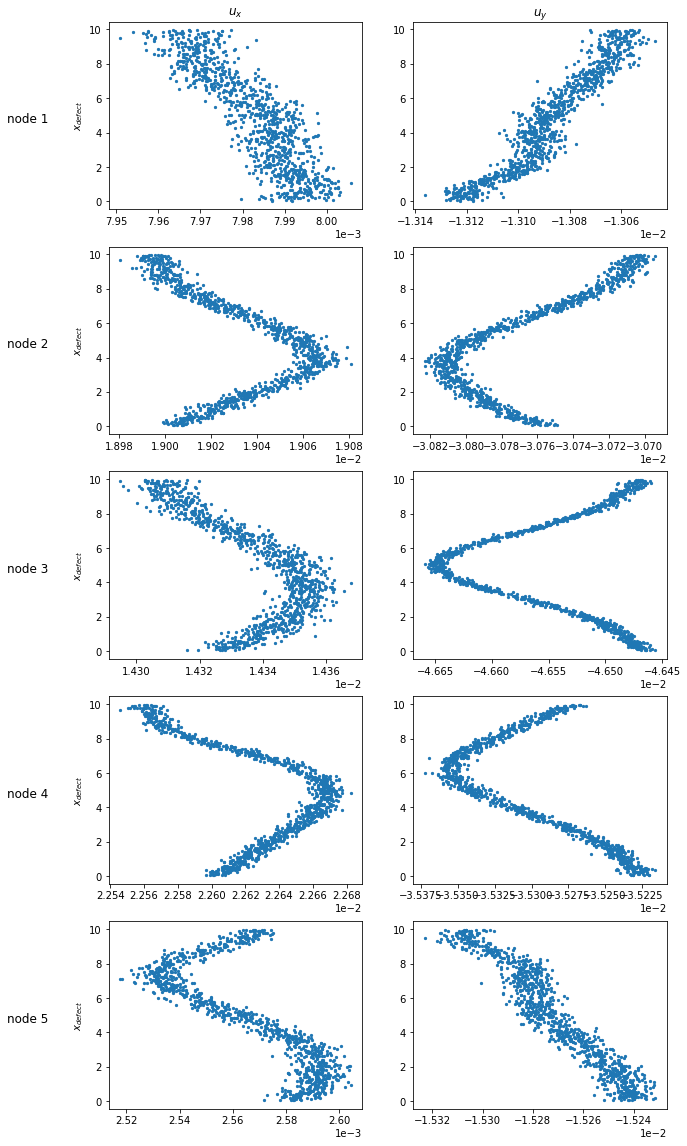

In [95]:
# plot a few hyperplanes of the dataset
fig, ax = plt.subplots(5,2, figsize=(10,20))
[ax.flat[i].scatter(measurements_noisy[:,i], defect_locs, s=5) for i in range(len(ax.flat))]
[ax.flat[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0)) for i in range(len(ax.flat))]
[ax[0,i].set_title(title) for i,title in enumerate([r'$u_x$',r'$u_y$'])]
[ax[i,0].text(-0.4, 0.46, r'node {}'.format(i+1), transform=ax[i,0].transAxes, fontsize=12) for i in range(ax.shape[0])]
[ax[i,0].set_ylabel(r'$x_{defect}$') for i in range(ax.shape[0])]
plt.show()

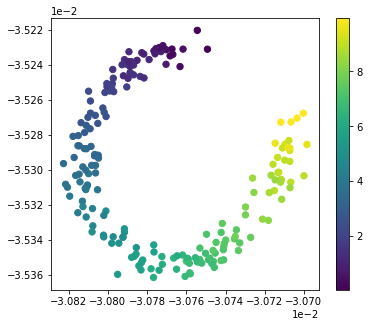

In [94]:
fig, ax = plt.subplots(figsize=(6,5))
plot1 = ax.scatter(measurements_noisy[::5,3], measurements_noisy[::5,7], c=defect_locs[::5], s=40)
[ax.ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y']]
fig.colorbar(plot1)
plt.show()

In [90]:
np.random.seed(1)
xscaler, yscaler = StandardScaler(), StandardScaler()
yit = yscaler.inverse_transform
xit = xscaler.inverse_transform
# X, y = xscaler.fit_transform(measurements_noisy[:,[3,7]]), yscaler.fit_transform(defect_locs[:,None]).reshape(-1)
X, y = xscaler.fit_transform(measurements_noisy), yscaler.fit_transform(defect_locs[:,None]).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
NN = MLPRegressor(solver='adam', hidden_layer_sizes=(20,20,20), activation='tanh', max_iter=10000, verbose=False, tol=1e-6)
NN.fit(X_train,y_train)

MLPRegressor(activation='tanh', hidden_layer_sizes=(20, 20, 20), max_iter=10000,
             tol=1e-06)

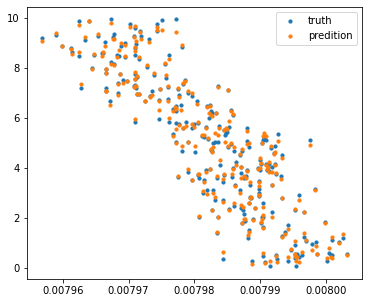

In [91]:
y_pred = NN.predict(X_test)
fig, ax = plt.subplots(figsize = (6,5))
loc = 0
ax.scatter(xit(X_test)[:,loc], yit(y_test[:,None]).reshape(-1), label='truth', s=10)
ax.scatter(xit(X_test)[:,loc], yit(y_pred[:,None]).reshape(-1), label='predition', s=10)
ax.legend()
plt.show()

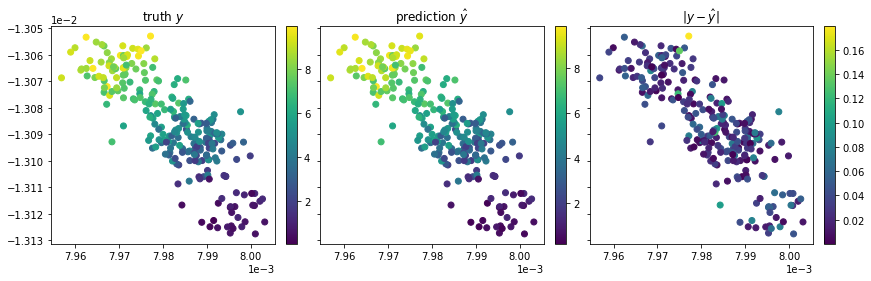

In [104]:
fig, ax = plt.subplots(1,3,figsize=(12,3.8), constrained_layout=True, sharey=True)
plot0 = ax[0].scatter(xit(X_test)[:,0], xit(X_test)[:,1], c=yit(y_test[:,None]).reshape(-1))
plot1 = ax[1].scatter(xit(X_test)[:,0], xit(X_test)[:,1], c=yit(y_pred[:,None]).reshape(-1))
plot2 = ax[2].scatter(xit(X_test)[:,0], xit(X_test)[:,1], c=np.abs(y_pred-y_test))
[plt.colorbar(plot, ax=ax[i]) for i, plot in enumerate([plot0, plot1, plot2])]
[ax[i].set_title(title) for i, title in enumerate([r'truth $y$', r'prediction $\hat y$', r'$|y - \hat y|$'])]
[axs.ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y'] for axs in ax]
plt.show()

Our data only spans across a (curved) band of the input domain. It might be interesting to check out the whole input space. For that prupose, we are setting up a meshgrid in hyperplane, i.e. a 2D subset of out input space. Rememember that the standardization squeezes most values in the interval $[-2,2]$. We define our grid in the standardized space, and then transform it back to original input space. We defined a function that repeats this scheme for an arbitraty amount of hyperplanes. You can play around with it by adapting the arguments in the function call.

In [182]:
def get_hyperplane_pred(*args):
    nrows, ncols = int(np.ceil(len(args)/3)), 3
    size = 5.
    fig, ax = plt.subplots(nrows, ncols, figsize=(size*ncols, 0.85*size*nrows), constrained_layout=True )
    
    grid_x, grid_y = np.mgrid[-3:3:100j, -3:3:100j]
    
    for i, arg in enumerate(args):
        grid_X = np.zeros((len(x_grid),10))
        grid_X[:,[arg[0],arg[1]]] = np.vstack((grid_x.flatten(),grid_y.flatten())).transpose()
        grid_pred = yit(NN.predict(grid_X)[:,None]).reshape(100,100)
               
        plot = ax.flat[i].contourf(xit(grid_X)[:,arg[0]].reshape(100,100),
                                   xit(grid_X)[:,arg[1]].reshape(100,100),
                                   grid_pred)
        plt.colorbar(plot, ax=ax.flat[i])
        [ax.flat[i].ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y']]
        
        # plot titles to distinguish the hyperplanes
        if (int(np.floor(arg[0]/2))==int(np.floor(arg[1]/2))):
            ax.flat[i].set_title(r'$u_x$ and $u_y$ in node {}'.format(int(np.floor(arg[0]/2))+1))
        elif (arg[0]%2 == arg[1]%2):
            ax.flat[i].set_title(r'$u_{}$ in nodes {} and {}'.format('x' if arg[0]%2==1 else 'y', int(arg[0]/2)+1, int(arg[1]/2)+1))
        else: 
            ax.flat[i].set_title(r'$u_{}$ in node {} and $u_{}$ in node {}'\
                                 .format('x' if arg[0]%2==1 else 'y', int(arg[0]/2)+1,
                                         'x' if arg[1]%2==1 else 'y', int(arg[1]/2)+1))
        

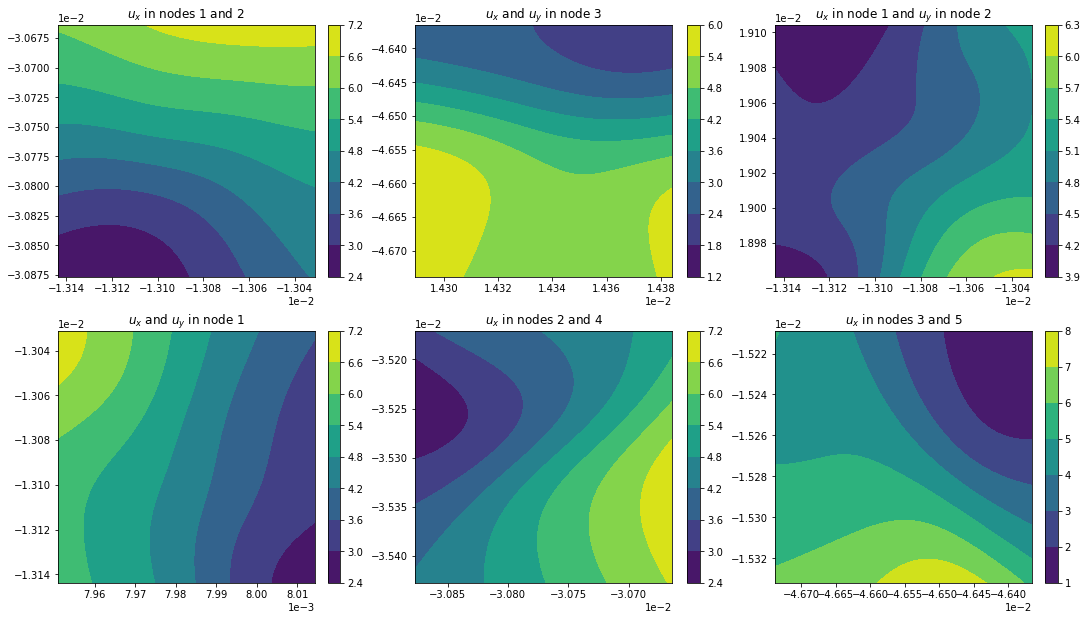

In [183]:
get_hyperplane_pred([1,3],[4,5],[1,2],[0,1],[3,7],[5,9])

In [181]:
# grid_x, grid_y = np.mgrid[-3:3:100j, -3:3:100j]
# grid_X = np.zeros((len(x_grid),10))
# grid_X[:,[3,7]] = np.vstack((grid_x.flatten(),grid_y.flatten())).transpose()
# # pred_grid = NN.predict(np.vstack((grid_x.flatten(),grid_y.flatten())).transpose())
# grid_pred = yit(NN.predict(grid_X)[:,None]).reshape(100,100)


# fix, ax = plt.subplots(figsize=(6,5))
# plot = ax.contourf(xit(grid_X)[:,3].reshape(100,100),
#                    xit(grid_X)[:,7].reshape(100,100),
#                    grid_pred)
# [ax.ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y']]
# ax.set_xlabel(r'$u_x$
# plt.colorbar(plot)
# plt.show()